# Run ISPC

This script runs ISPC

## py conversion

In [1]:
#jupyter nbconvert --to python slurm_create-data_preproc.ipynb

## Imports 

In [2]:
import warnings
import sys  
import random
# import logging

import deepdish as dd
import numpy as np

import brainiak.eventseg.event
import nibabel as nib
import nilearn as nil
# Import a function from BrainIAK to simulate fMRI data
import brainiak.utils.fmrisim as sim  

from nilearn.input_data import NiftiMasker

import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 



from brainiak import image, io
from scipy.stats import stats
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from nilearn import datasets, plotting
from nilearn.plotting import plot_roi
from nilearn.input_data import NiftiSpheresMasker

from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img,index_img
from nilearn import image
from nilearn import masking
from nilearn.plotting import view_img
from nilearn.image import resample_to_img

from nilearn.image import concat_imgs, resample_img, mean_img
from nilearn.plotting import view_img

import numpy as np 
import os
import os.path
import scipy.io
import nibabel as nib
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask, compute_brain_mask, unmask
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from copy import deepcopy

# Brainiak # 
from brainiak import image, io 
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc,
                          timeshift_isc, phaseshift_isc,
                          compute_summary_statistic)
from brainiak.io import load_boolean_mask, load_images
from statsmodels.stats.multitest import multipletests
from nilearn.plotting import plot_stat_map
%matplotlib inline

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
random.seed(10)

## custom helper functions 

In [4]:
from utils_anal import load_epi_data

## directories 

In [5]:
top_dir = '/jukebox/graziano/coolCatIsaac/MEI'
data_dir = top_dir + "/data"
work_dir = data_dir + '/work'
mask_dir = work_dir + '/masks'
behav_dir = top_dir + '/data/behavioral'
rois_dir = data_dir + "/rois"
fmri_prep = data_dir + '/bids/derivatives/fmriprep'
conf_dir = work_dir + '/confs'
preproc_dir = work_dir + '/preproc'
isc_dir = work_dir + '/isc_dat'


## main vars 

In [6]:
### sub_list ###
"""

========================================================
===== ~~~ Summary ALL ~~~ ===== 
========================================================
Initially exclude: sub-001, sub-003, sub-011, sub-012, sub-014, sub-015, sub-029 (3+ runs still available tho)
Maybe exclude: sub-014, sub-024, sub-037 (No button presses)
Maybe exclude: sub-020, sub-022, sub-031
total exclude = 10


~~~~~~~ BEHAVIORAL ~~~~~~~~~~
~~~ Summary behavioral ~~~

========================================================
========================================================
No button presses: sub-014, sub-024, sub-037 

========================================================
========================================================
sub-003: Extra row observed for external, which was manually deleted. Should be fine to rerun -- i removed from bad_subs
    - current brushing: 87, TRUE: 88 for THREE runs. last run when there was an issue and scan had to be restarted
    - Scan 6 == 1 run of brushing
    - Scan 7 = 3 runs of brushing 
    - ** no idea when run 7 was started tho! will prolly need to throw out! For now we can process all
sub-014: NO internal OR external bpress, curious! ---should be fixed now
    - changed excel data to include two null columns
    - ALSO only 30 TRs for the second run epi data. i went into the room to adjust runny eyes. Data for this run is not usable. but after should
      be okay if u want to put in the effort 
sub-015: less than 24 runs ---should be fixed now w custom code (but keep out of main run cuz will throw an error otherwise )
    - SUMMARY: need to exclude the office run 3 for fMRI but can include run 3 in behavioral, no data at all for CAKE
    - DID NOT add the 'mov_name' component to the custom code, will need to implment from current iteration
    - **** Use external, ignore internal for now... cuz internal is fuqd. Can preprocess all 7 tho

~~~~~~~ FMRI ~~~~~~~~~~
~~~ Summary fMRI ~~~
sub002: 
 - appended two TRs onto the last run, copied from the third to last TR. should be good to use
sub-003, sub-012, sub-014, sub-015, sub-029: 
 - Five runs usable, will need to incorporate them at some point 
sub-001: external usable - first three runs 

========================================================
========================================================
subject 002: (usable, with adjustment)
    only has 92 INSTEAD OF 94 TRs for the FINAL run of shrek. i think cuz i turned off the scanner
    too soon, which didn't account for 4 TRs of buffer? Yep! end tr is 390, (388, 112179). so duplicate TRs maybe.
    - Temporarily eliminate! or duplicate TRs 
    
sub-003: (usable, 5 runs)
- Scan 6 == 1 run of brushing
- Scan 7 = 3 runs of brushing 
*** need to re-preprocess, then append 6 and 7 together; or just throw out this one cuz idk when scan started

sub-011: (usable)
- not preprocessed 
sub-012 (5 runs usable, one run idk)
- I'll need to post process. It seems that an earbud fell out while reading the directions for run 5 
summary: the fifth run  needs to be discarded. all others are usable.
see the behav data: 
sub_dic['External']['oragami']
{'run-1': {'start_tr': 94, 'end_tr': 188, 'bpress': -1},
 'run-2': {'start_tr': 188, 'end_tr': 282, 'bpress': [100.81657150003593]},
 'run-3': {'start_tr': 282, 'end_tr': 376, 'bpress': [88.26579949003644]},
 'run-4': {'start_tr': 378,
  'end_tr': 472,
  }
- you can see taht the start TR is 94!! that's becuz i had to go into the scan room during the instructions screen.
- this is producing the wrong indexing -- becuz the scan doesn't contain enough TRs according to the behavioral data:
    - run 4 of shrek only has 12 TRs because we start at TR 94.
- im not sure when the scan actually started, but if i wanted to try to include i could 
    set the start TR to 1 -- essentially suggesting that the first TR was collected on the external 'waiting 
    for TR' flip. might as well try at some point, but exclude for now
    - this would involve just subtracting 94 from all start end end TRs i think
See the excel behavioral file for further notes notes
this 

sub-014 - no button press data and 7 runs (5 runs usable, but no bpress)
    - same problem as above -- i went into the scanner room during the instructions period to wipe eyes
    {'run-1': {'start_tr': 237, 'end_tr': 323, 'bpress': -1},
     'run-2': {'start_tr': 329, 'end_tr': 415, 'bpress': -1},
     'run-3': {'start_tr': 417, 'end_tr': 503, 'bpress': -1},
     'run-4': {'start_tr': 509, 'end_tr': 595, 'bpress': -1}}

sub-029: (5 runs usable)
- scanner malfunction, maybe possible to stitch together run 6 cuz i started on the *tenth* TR

========================================================
========================================================
Left handed: (sub-020, sub-022, sub-032)
    - sub-020: also no button presses, appeared to be awake tho
    - sub-022: lefty
    - sub-031: ambidexterious, great data
========================================================
========================================================
"""

## adjusted sublist 
sub_list = [
    'sub-002', 'sub-004', 'sub-005','sub-006','sub-007','sub-008','sub-009','sub-010',
    'sub-013','sub-016','sub-017','sub-018','sub-019','sub-020','sub-021',
    'sub-022','sub-023','sub-024','sub-025','sub-026','sub-027','sub-028','sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040'
]

## ALL SUBLIST
sub_list = [
    'sub-002', 'sub-003', 'sub-004', 'sub-005','sub-006','sub-007','sub-008','sub-009','sub-010', 'sub-012',
    'sub-013','sub-014', 'sub-015', 'sub-016','sub-017','sub-018','sub-019','sub-020','sub-021',
    'sub-022','sub-023','sub-024','sub-025','sub-026','sub-027','sub-028', 'sub-029', 'sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040', 'sub-041'
]
###### LOADING VARS #######




In [7]:
## TR length of each movie ## 
mov_len_dic = {
'oragami' :  82,
'shrek' : 90,
'sherlock' : 98,
'brushing' : 88,
'cake' : 99,
'office' : 102    
}

voxel_num = 112179

num_parc = 400


# load atlas 

In [8]:
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc)
atlas_filename = dataset.maps
labels = dataset.labels

print(f"Atlas ROIs are located in nifti image (4D) at: {atlas_filename}")

Atlas ROIs are located in nifti image (4D) at: /usr/people/isaacrc/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz


In [9]:
labels[:3]

array([b'7Networks_LH_Vis_1', b'7Networks_LH_Vis_2',
       b'7Networks_LH_Vis_3'], dtype='|S37')

In [10]:
# Load  sample data for resampling
resamp_run = load_epi_data(fmri_prep, 'sub-007', 2, "MNI")
# Load parcellation
d = nib.load(atlas_filename)
atlas_nii = resample_to_img(d, resamp_run, interpolation='nearest')
# Get parcellation fdata
atlas_img = atlas_nii.get_fdata()
# paracellations scheme
print(f'count parc:{len(np.unique(atlas_nii.get_fdata()))}')
print("shape of atlas nii object", atlas_img.shape)



Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:401
shape of atlas nii object (78, 93, 65)


### plot

In [11]:
"""
## Set the ROI num ## 
roi_num = 183
print("Begin Parc", roi_num)

# How many voxels for this ROI? #
num_voxels = np.sum(atlas_img == roi_num)
print("num voxels in one parcel:", num_voxels)
# Create an empty that is the shape of d
roi_tem = np.zeros(atlas_nii.shape)
# set all cases where parcel is equal to roi_num, equal to one, everything else zero (creates a mask)
roi_tem[atlas_img == roi_num] = 1
# Create a nift image of the mask
roi_img = nib.Nifti1Image(roi_tem, affine = atlas_nii.affine, header = atlas_nii.header)
roi_name = labels[roi_num]
print(roi_name[10:].decode("utf-8"))
#nib.save(roi_img, rois_dir+'/'+ roi_name.decode("utf-8"))

plot_roi(roi_img)
"""

'\n## Set the ROI num ## \nroi_num = 183\nprint("Begin Parc", roi_num)\n\n# How many voxels for this ROI? #\nnum_voxels = np.sum(atlas_img == roi_num)\nprint("num voxels in one parcel:", num_voxels)\n# Create an empty that is the shape of d\nroi_tem = np.zeros(atlas_nii.shape)\n# set all cases where parcel is equal to roi_num, equal to one, everything else zero (creates a mask)\nroi_tem[atlas_img == roi_num] = 1\n# Create a nift image of the mask\nroi_img = nib.Nifti1Image(roi_tem, affine = atlas_nii.affine, header = atlas_nii.header)\nroi_name = labels[roi_num]\nprint(roi_name[10:].decode("utf-8"))\n#nib.save(roi_img, rois_dir+\'/\'+ roi_name.decode("utf-8"))\n\nplot_roi(roi_img)\n'

In [12]:
# Load in network labels
label_fn = 'brainiak-aperture-isc-data/Schaefer2018_400Parcels_17Networks_order.txt'
with open(label_fn) as f:
    networks = [' '.join((label.split('_')[1][0], label.split('_')[2]))
                for label in f.readlines()]
    
# Get sorted unique network labels
idxs = np.unique(networks, return_index=True)[1]
network_labels = [networks[idx] for idx in sorted(idxs)]

# Get middle index for each network for plotting
network_idxs = [int(np.median([i for i, n in enumerate(networks)
                                if n == network]))
                for network in network_labels]

In [13]:
network_labels

['L VisCent',
 'L VisPeri',
 'L SomMotA',
 'L SomMotB',
 'L DorsAttnA',
 'L DorsAttnB',
 'L SalVentAttnA',
 'L SalVentAttnB',
 'L LimbicB',
 'L LimbicA',
 'L ContA',
 'L ContB',
 'L ContC',
 'L DefaultA',
 'L DefaultB',
 'L DefaultC',
 'L TempPar',
 'R VisCent',
 'R VisPeri',
 'R SomMotA',
 'R SomMotB',
 'R DorsAttnA',
 'R DorsAttnB',
 'R SalVentAttnA',
 'R SalVentAttnB',
 'R LimbicB',
 'R LimbicA',
 'R ContA',
 'R ContB',
 'R ContC',
 'R DefaultA',
 'R DefaultB',
 'R DefaultC',
 'R TempPar']

# Select network for analysis and plot

In [18]:
# Get labels for parcels in left DMN A network
net_lab = 'R ContC' #'L DefaultB'  #'R ContC' #R DorsAttnB  #R VisPeri  #R SalVentAttnA #'R TempPar' #'L SomMotA'

## Target Conditions
targ_cond = "External"

## movie repetitions ##
#m_reps = 1
targ_run = 1

## Get labels associated with the target network ## 
targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1

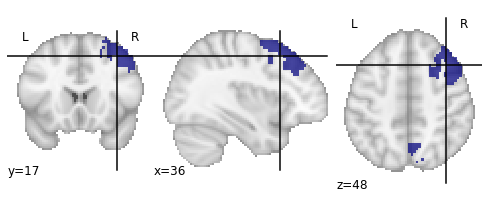

In [19]:
# Create an empty that is the shape of d
roi_tem = np.zeros(atlas_nii.shape)
# set all cases where parcel is equal to roi_num, equal to one, everything else zero (creates a mask)
for parcel in targ_net:
    roi_tem[atlas_img == parcel] = 1
    
# Create a nift image of the mask
roi_img = nib.Nifti1Image(roi_tem, affine = atlas_nii.affine, header = atlas_nii.header)
#nib.save(roi_img, rois_dir+'/'+ roi_name.decode("utf-8"))


mPFC_coords = (10,10, 45)
pcc_coords = (10,-40, 45)

#plot_roi(roi_img,cut_coords = pcc_coords)
plot_roi(roi_img)

# variables

In [20]:
# Get labels for parcels in left DMN A network
vox_roi = len(np.where(roi_tem ==1)[2])
print(f'using {net_lab} with {vox_roi} voxels')

using R ContC with 1124 voxels


In [21]:
## Load mask
## mask image ##
mask_img = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
#mask_img = nib.load(mask_dir + "/shaef_gm_MNI_mask.nii")


## how many TRs on the end? ## 
tr_buffer = 4 

# cuttoff the countdown 
trim_start = 4 # cuts off first 4 TRs

## number of runs to iterate over
epi_runs = 6

## load the runs to be included for each subject ## 
sub_run_inc = np.load(behav_dir + '/sub_run_inc.npy', allow_pickle = True).item()

## how many TRs to iterate around the button press
tr_range = np.arange(-3,10)

# this is the window which gannot be impeded by a second button press 
range_len = len(tr_range)
no_interfere = len(np.where(tr_range>0)[0])
print(f'total TRs to be extracted around the bpress: {range_len}\n total trs extracted post bpress: {no_interfere}')

total TRs to be extracted around the bpress: 13
 total trs extracted post bpress: 9


### begin

In [22]:
external = {}
internal = {}
m_rep_int = {}
m_rep_ext = {}

for run in range(targ_run, targ_run + 1):
    for sub in sub_list:
        ### fMRI load ###
        sub_dic_fmri = np.load(f'{preproc_dir}/{sub}_fwhm6_conf.npy', allow_pickle=True).item()
        print(f'start {sub}')
        ## BEHAVIORAL ##
        sub_dic_behav = np.load(os.path.join(behav_dir, f'{sub}_behav.npy'), allow_pickle=True).item()

        # Create subject number 
        sub_num = int(sub[-3:])

        for epi_index in range(0, epi_runs):
            # Add one to the index to create 1-6 runs
            epi_run = epi_index + 1

            # check if run is to be included 
            if not sub_run_inc[sub][epi_run]: continue

            # Get the movie name
            mov_name = sub_dic_behav['mov_order'][epi_index]

            # Create an empty array for the movie runs, append four TRs to account for the 4 trailing TRs, subtract
            # the quantity of TRs that we are trimming from the front 
            mov_runs = np.zeros((range_len, vox_roi, 0))

            print(f'movie: {mov_name} with shape {mov_runs.shape}')

            # Get the fMRI run for the current epi_index
            fmri_run = sub_dic_fmri[epi_run]

            # Loop over runs
            #for run in range(1, m_reps + 1):
            # Is this an internal or external run?
            key = 'External' if (sub_num % 2 == 1 and epi_index < 3) or (sub_num % 2 == 0 and epi_index >= 3) else 'Internal'

            ### only do internal for now ##
            if key != targ_cond: continue

            ## get behavioral data
            bpress_arr = sub_dic_behav[key][mov_name][f'run-{str(run)}']['bpress']

            ## continue if no button presses
            if bpress_arr == -1:
                print(f'NO button presses {sub} {run}\n')
                continue


            # Begin slicing fMRI data #
            start_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['start_tr']
            end_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['end_tr']
            run_slice = fmri_run[(start_tr + trim_start):end_tr, :]
            print(f'run{run} bpress count is: {len(bpress_arr)}')
            print(f'start tr {start_tr}, end TR {end_tr}, length of fMRI run {fmri_run.shape}')
            assert fmri_run.shape[0] >= end_tr, 'end TR is greater than fMRI TRs available'

            # calculate differences between button presses, and append the time stamp of the end of scan
            difs = np.diff(np.hstack((bpress_arr, (end_tr - start_tr) * 1.5)))

            ## empty array to append if TR doesn't exist or conflicts with another button pres!
            empty = np.zeros((run_slice.shape[1])) ## number of voxels

            bpress_mat = []
            for idx, bpress in enumerate(bpress_arr):
                # Find the tr that each onset occured - convert from seconds to TR
                bpress_tr = round(bpress/1.5)
                print(f'\ntime of bpress {bpress},  tr is: {bpress_tr}, and next tr is {difs[idx]} away')
                assert bpress_tr < end_tr, print('TR extends past fMRI data, what on earth is going on!')

                temp = []
                ## for each tr in the TR range [likely this is 12 total trs]
                for num_tr in tr_range:
                    try:
                        # IF tr exists in the range of TRs add to temp array before averaging in the next step
                        current_bpress_tr = run_slice[bpress_tr+num_tr]
                        # if no error is thrown, run a check
                        # if the distance between the current and next tR is less than 1.5*6 seconds, do not extract that data
                        # and fill with empty zeros to be averaged over later
                        # 6 is the number of TRs ahead. we convert to seconds by multiplying by 1.5
                        if difs[idx] < 1.5 * num_tr:
                            temp.append(empty)
                            #print(f'INTERFERE DIF: cur TR is:{num_tr}, next bpress is {int(difs[idx] /1.5)} trs away')
                        else:
                            # add the correct voxel activation for the given TR 
                            temp.append(current_bpress_tr)
                            #print(f'CORRECT {current_bpress_tr[:3]}, length of TR activ is {len(current_bpress_tr)}')

                    except:
                        # if it doesn't exist, add an empty vector
                        temp.append(empty)
                        #print(f'INTERFERE Out of BNDS: bpress_tr {bpress_tr}, index {bpress_tr+num_tr}; total TRs {end_tr - start_tr}')
                    #print(f'FINISHED the {num_tr} TR')
                bpress_mat.append(temp)
                #print('FINISHED ONE BUTTN PRESS\n\n')

            ## convert list into numpy array
            bpress_mat = np.dstack(bpress_mat)
            print(f'num bpress: {len(bpress_arr)}, TRs: {bpress_mat.shape[0]}, voxels: {bpress_mat.shape[1]}')
            print(f'shape of bpress for {sub} is {bpress_mat.shape}')
            ## check that we have activation for at least one button press
            assert np.any(bpress_mat), f'NO BPRESSES FOR {sub}'

            ## once we've finished iterating over all button press, average each bpress matrix element-wise!
            #bpress_mat_av = np.mean(bpress_mat, axis =2)
            bpress_mat_av = np.nanmean(np.where(bpress_mat != 0, bpress_mat, np.nan), axis =2)
            # re-insert zeros after averaging, ignoring TRs that had no activation
            bpress_mat_av = np.where(bpress_mat_av != np.nan, bpress_mat_av, 0)

            # convert back to whole brain 4D image, instead of 2d
            bpress_nii = unmask(bpress_mat_av, mask_img)
            print(f'convert bpress averages back to nii: {bpress_nii.shape}')

            # Convert to 4d numpy array
            f_dat_4d = bpress_nii.get_fdata()
            
            targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1

            # loop through all TRs and get the target voxel pattern #
            bpress_pat = np.column_stack([f_dat_4d[atlas_img == parcel, :].T
                            for parcel in targ_net])

            print(f'now extract voxel TR activations for target ROI: {np.dstack(bpress_pat).shape}\n\n')

            # expand to three dimensions for stacking 
            #bpress_pat_exp = np.expand_dims(np.dstack(bpress_pat), 2)
            bpress_pat_exp = np.expand_dims(bpress_pat, 2)
            #print(f'expand! {bpress_pat.shape}')

            # Stack the run slice with the mov_runs array
            #mov_runs = np.dstack((mov_runs, bpress_pat))
            mov_runs = np.dstack((mov_runs, bpress_pat_exp))
            print(f'stacked! {mov_runs.shape}')
            #assert mov_runs.shape[2] == 4, 'wrong numer of repetitions'

            # set outer loop #
            if key == 'External':
                target_dict = external
            else:
                target_dict = internal

            if mov_name not in target_dict:
                target_dict[mov_name] = mov_runs
            else:
                #mov_runs = np.expand_dims(mov_runs, 3)
                target_dict[mov_name] = np.dstack((target_dict[mov_name], mov_runs))
        print(f'\n subject {sub} finished \n')

    ## save into a repetition dictionary ## 
    m_rep_ext[run] = external
    m_rep_int[run] = internal



    print('done')
        
            
            
            
            
            
            

start sub-002
movie: shrek with shape (13, 1124, 0)
movie: sherlock with shape (13, 1124, 0)
movie: oragami with shape (13, 1124, 0)
movie: office with shape (13, 1124, 0)
run1 bpress count is: 2
start tr 8, end TR 114, length of fMRI run (437, 112179)

time of bpress 34.00292439600162,  tr is: 23, and next tr is 47.079010672998265 away

time of bpress 81.08193506899988,  tr is: 54, and next tr is 77.91806493100012 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-002 is (13, 112179, 2)


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: Mean of empty slice


convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)
movie: cake with shape (13, 1124, 0)
run1 bpress count is: 2
start tr 7, end TR 110, length of fMRI run (422, 112179)

time of bpress 55.51788171500084,  tr is: 37, and next tr is 27.242092001004494 away

time of bpress 82.75997371600533,  tr is: 55, and next tr is 71.74002628399467 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-002 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)
movie: brushing with shape (13, 1124, 0)
run1 bpress count is: 1
start tr 7, end TR 99, length of fMRI run (379, 112179)

time of bpress 78.56357682299858,  tr is: 52, and next tr is 59.436423177001416 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-002 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)
movie: sherlock with shape (13, 1124, 0)
NO button presses sub-008 1


 subject sub-008 finished 

start sub-009
movie: cake with shape (13, 1124, 0)
NO button presses sub-009 1

movie: office with shape (13, 1124, 0)
NO button presses sub-009 1

movie: brushing with shape (13, 1124, 0)
run1 bpress count is: 2
start tr 7, end TR 99, length of fMRI run (379, 112179)

time of bpress 58.74823587201536,  tr is: 39, and next tr is 37.73500683705788 away

time of bpress 96.48324270907324,  tr is: 64, and next tr is 41.51675729092676 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-009 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)
movie: shrek with shape (13, 1124, 0)
movie: oragami with shape (13, 1124, 0)
movie: sherloc

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)
movie: sherlock with shape (13, 1124, 0)
run1 bpress count is: 1
start tr 7, end TR 109, length of fMRI run (417, 112179)

time of bpress 15.680049269925803,  tr is: 10, and next tr is 137.3199507300742 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-016 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)

 subject sub-016 finished 

start sub-017
movie: cake with shape (13, 1124, 0)
NO button presses sub-017 1

movie: office with shape (13, 1124, 0)
NO button presses sub-017 1

movie: brushing with shape (13, 1124, 0)
run1 bpress count is: 1
start tr 11, end TR 103, length of fMRI run (383, 112179)

time of bpress 45.74890928899913,  tr is: 30, and next tr is 92.25109071100087 away
num bpress: 1, TRs: 13, voxels: 11217

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)
movie: brushing with shape (13, 1124, 0)
run1 bpress count is: 2
start tr 8, end TR 100, length of fMRI run (378, 112179)

time of bpress 111.83011578698643,  tr is: 75, and next tr is 6.898887810995802 away

time of bpress 118.72900359798223,  tr is: 79, and next tr is 19.270996402017772 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-022 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)
movie: cake with shape (13, 1124, 0)
run1 bpress count is: 2
start tr 7, end TR 110, length of fMRI run (423, 112179)

time of bpress 36.594351576059125,  tr is: 24, and next tr is 24.77811437100172 away

time of bpress 61.372465947060846,  tr is: 41, and next tr is 93.12753405293915 away
num bpress: 2, TRs: 13, voxels: 112179
shape 

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)

 subject sub-028 finished 

start sub-029
movie: brushing with shape (13, 1124, 0)
NO button presses sub-029 1

movie: office with shape (13, 1124, 0)
run1 bpress count is: 3
start tr 7, end TR 113, length of fMRI run (441, 112179)

time of bpress 82.58719657408074,  tr is: 55, and next tr is 47.64400661503896 away

time of bpress 130.2312031891197,  tr is: 87, and next tr is 11.372997503960505 away

time of bpress 141.6042006930802,  tr is: 94, and next tr is 17.3957993069198 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-029 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)
movie: sherlock with shape (13, 1124, 0)
movie: oragami with shape (13, 1124, 0)
movie: shrek with shape (13, 1124, 0)

 subject sub-029 finis

num bpress: 10, TRs: 13, voxels: 112179
shape of bpress for sub-034 is (13, 112179, 10)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)
movie: brushing with shape (13, 1124, 0)
run1 bpress count is: 5
start tr 7, end TR 99, length of fMRI run (377, 112179)

time of bpress 33.793793763034046,  tr is: 23, and next tr is 30.151002514641732 away

time of bpress 63.94479627767578,  tr is: 43, and next tr is 27.759005497209728 away

time of bpress 91.7038017748855,  tr is: 61, and next tr is 24.394980324897915 away

time of bpress 116.09878209978342,  tr is: 77, and next tr is 12.95702204015106 away

time of bpress 129.05580413993448,  tr is: 86, and next tr is 8.94419586006552 away
num bpress: 5, TRs: 13, voxels: 112179
shape of bpress for sub-034 is (13, 112179, 5)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 1124, 1)
movie: oragami with shape (13, 1124, 0)
run1 bpress count is: 6
start tr 8, end TR 94, length of fMRI run (361, 112179)

time of bpress 17.67814728501253,  tr is: 12, and next tr is 12.618125921930186 away

time of bpress 30.296273206942715,  tr is: 20, and next tr is 8.897014623973519 away

time of bpress 39.19328783091623,  tr is: 26, and next tr is 14.886994605069049 away

time of bpress 54.08028243598528,  tr is: 36, and next tr is 28.663019553991035 away

time of bpress 82.74330198997632,  tr is: 55, and next tr is 27.63889082300011 away

time of bpress 110.38219281297643,  tr is: 74, and next tr is 18.617807187023573 away
num bpress: 6, TRs: 13, voxels: 112179
shape of bpress for sub-041 is (13, 112179, 6)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 1124, 13)


stacked! (13, 112

# ISC ANAL

In [23]:
#anal = m_rep_int[4]['sherlock']
anal = m_rep_ext[1]['sherlock']

anal.shape

(13, 1124, 9)

In [24]:
# Transpose input data to compute intersubject pattern correlation
ispcs = isfc(np.rollaxis(anal, 1, 0),
                    pairwise=False, vectorize_isfcs=False,
                    summary_statistic='mean')

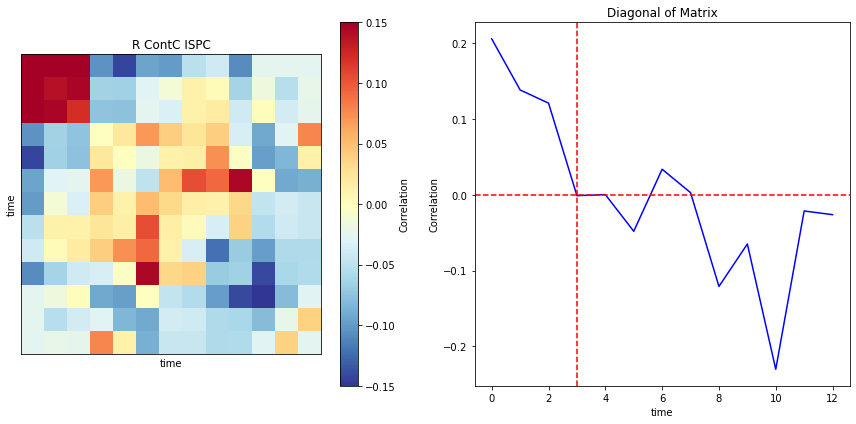

In [25]:
# Plot time-point-by-time-point intersubject pattern correlation
vmin, vmax = -0.15, 0.15

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Matrix
ispc = ispcs  # Choose the matrix to plot (intact_ispcs or scram_ispcs)
title = f'{net_lab} ISPC'  # Choose the appropriate title
image = axs[0].matshow(ispc, vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
axs[0].set_title(title)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('time')
axs[0].set_ylabel('time')
cbar = plt.colorbar(image, ax=axs[0])  # Add colorbar
cbar.set_label('Correlation')  # Set colorbar label

# Second plot: Seaborn lineplot with vertical line
diagonal = np.diagonal(ispc)
time_points = np.arange(len(diagonal))
axs[1] = sns.lineplot(x=time_points, y=diagonal, color='blue')
axs[1].set_title('Diagonal of Matrix')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Correlation')
axs[1].axvline(x=3, color='red', linestyle='--')  # Vertical line at the third tick
axs[1].axhline(y=0, color='red', linestyle='--')  # Horizotnal line at 0


plt.tight_layout()
plt.show()
